<a href="https://colab.research.google.com/github/Sathwik-i9/Basicml/blob/main/Bank_Churn_%F0%9F%93%8A%F0%9F%8F%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2008274%2F3322096%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240219%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240219T132504Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D887db8f53f84603b53cf2ffd51af442e2b12570821cfd1e70b988e1260d9b69cbbf5ade87783f8de1e09c5ec91e8e962b3f79615ab5c9a5fa022437024a84cde4d0e0ede4a5bc95da0cc62e33439654763abe9ded936c12fd890c1bf674b7343db51bf3c896693fb3d4010be4386982b450ab33f775d56f19c2b3bfdb6a255449bd12afcdaa76341f5c9ff8dde563707acf33dd9528301c5396930e8838f41ab243ae369e8bb383902ea038a6373b5f825ac323950b34cb96018a804b56d84f6c4f6606abc5ea4df8f3d027f2151b8c6cbfc8719ee00b5f0dc03adb228e281abc9726b831a17afb2519b20d5f41faf111a4084b5209a167227dc3a74e8250f59'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: bank-customer-churn-prediction
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor as xGBRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
df = pd.read_csv('Churn_Modelling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
(df.isnull().sum() / df.shape[0]*100).sort_values(ascending=False)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [6]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Graphs

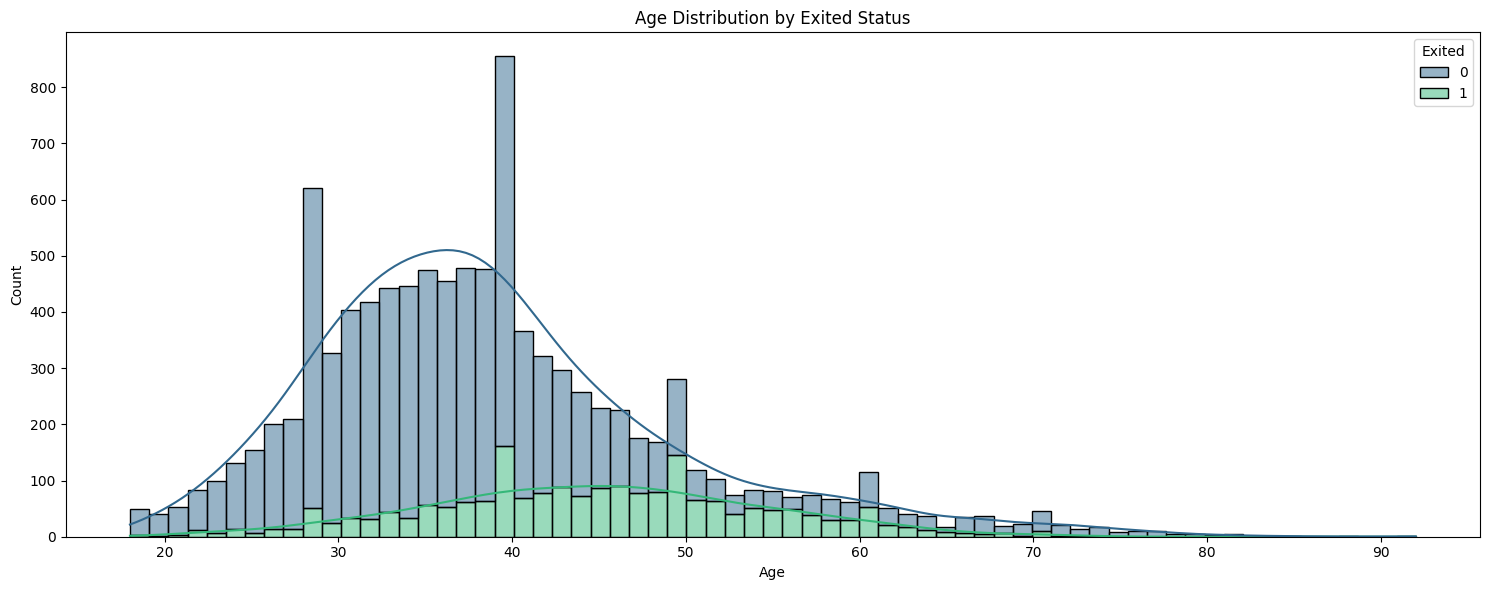

In [7]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df, x='Age', hue='Exited',  multiple="stack",kde=True, palette="viridis")
plt.title('Age Distribution by Exited Status')

plt.tight_layout()
plt.show()

In [8]:
mode = df['Age'][df['Exited'] == 0].mode()[0]
mean = df['Age'][df['Exited'] == 0].mean()
median = df['Age'][df['Exited'] == 0].median()
mode_exit = df['Age'][df['Exited'] == 1].mode()[0]
mean_exit= df['Age'][df['Exited'] == 1].mean()
median_exit = df['Age'][df['Exited'] == 1].median()

print("-----------------------------------------------------")
print("|    Statistics    |  Exited = 0 |  Exited= 1       |")
print("-----------------------------------------------------")
print(f"| Mode             |  {mode:<9}  |  {mode_exit:<14}  |")
print(f"| Median           |  {median:<9}  |  {median_exit:<14}  |")
print(f"| Mean             |  {mean:<9.2f}  |  {mean_exit:<14.2f}  |")
print("-----------------------------------------------------")


-----------------------------------------------------
|    Statistics    |  Exited = 0 |  Exited= 1       |
-----------------------------------------------------
| Mode             |  35         |  46              |
| Median           |  36.0       |  45.0            |
| Mean             |  37.41      |  44.84           |
-----------------------------------------------------


In [9]:
q1 = df['Age'].quantile(0.25)
q3 = df['Age'].quantile(0.75)

q1_exit_0 = df['Age'][df['Exited'] == 0].quantile(0.25)
q3_exit_0 = df['Age'][df['Exited'] == 0].quantile(0.75)

q1_exit_1 = df['Age'][df['Exited'] == 1].quantile(0.25)
q3_exit_1 = df['Age'][df['Exited'] == 1].quantile(0.75)


print("Quartiles for Age Distribution when Exited = 0:")
print(f"Q1: {q1_exit_0}, Q3: {q3_exit_0}\n")

print("Quartiles for Age Distribution when Exited = 1:")
print(f"Q1: {q1_exit_1}, Q3: {q3_exit_1}")


Quartiles for Age Distribution when Exited = 0:
Q1: 31.0, Q3: 41.0

Quartiles for Age Distribution when Exited = 1:
Q1: 38.0, Q3: 51.0


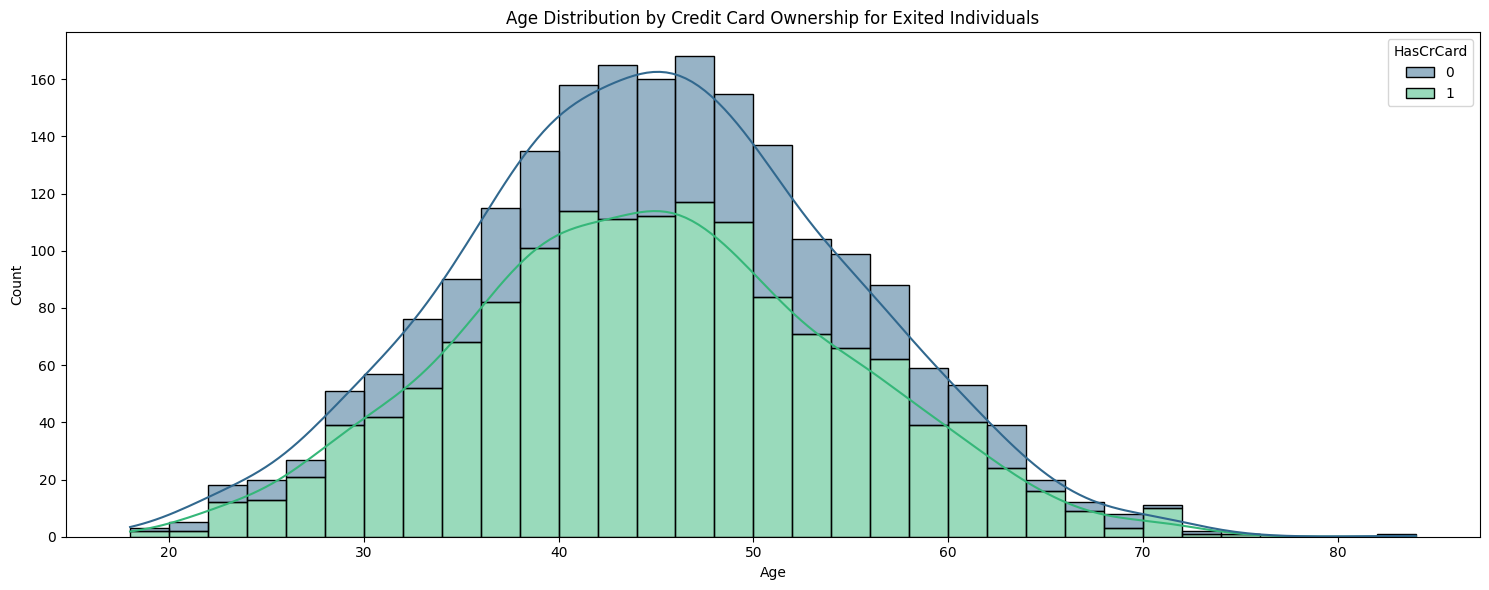

In [10]:
df_exited = df[df['Exited'] == 1]

plt.figure(figsize=(15, 6))

sns.histplot(data=df_exited, x='Age', hue='HasCrCard', multiple="stack", kde=True, palette="viridis")

plt.title('Age Distribution by Credit Card Ownership for Exited Individuals')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
mode = df_exited['Age'][df['HasCrCard'] == 0].mode()[0]
mean = df_exited['Age'][df['HasCrCard'] == 0].mean()
median = df_exited['Age'][df['HasCrCard'] == 0].median()
mode_exit = df_exited['Age'][df['HasCrCard'] == 1].mode()[0]
mean_exit= df_exited['Age'][df['HasCrCard'] == 1].mean()
median_exit = df_exited['Age'][df['HasCrCard'] == 1].median()

print("-----------------------------------------------------")
print("|    Statistics  |  HasCrCard = 0 |  HasCrCard= 1   |")
print("-----------------------------------------------------")
print(f"| Mode           |  {mode:<9}  |  {mode_exit:<14}    |")
print(f"| Median         |  {median:<9}  |  {median_exit:<14}    |")
print(f"| Mean           |  {mean:<9.2f}  |  {mean_exit:<14.2f}    |")
print("-----------------------------------------------------")


-----------------------------------------------------
|    Statistics  |  HasCrCard = 0 |  HasCrCard= 1   |
-----------------------------------------------------
| Mode           |  47         |  46                |
| Median         |  45.0       |  45.0              |
| Mean           |  45.28      |  44.65             |
-----------------------------------------------------


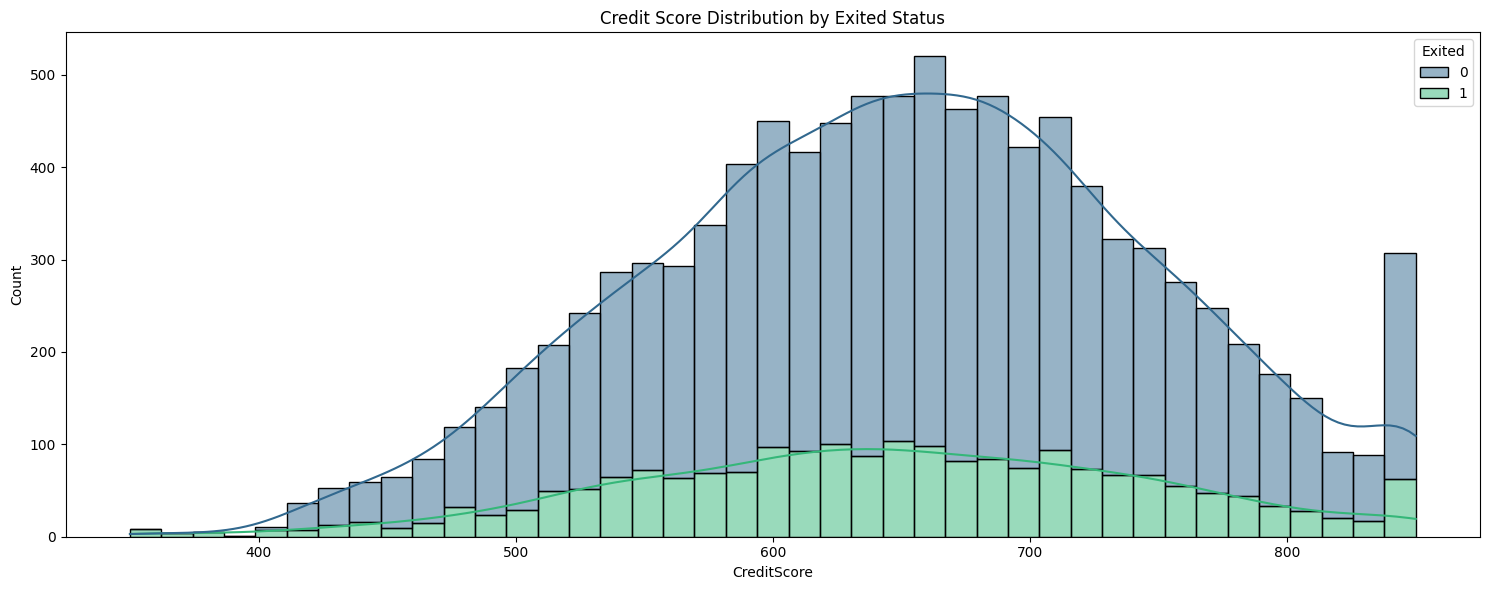

In [12]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df, x='CreditScore', hue='Exited',  multiple="stack",kde=True,  palette="viridis")
plt.title('Credit Score Distribution by Exited Status')

plt.tight_layout()
plt.show()

In [13]:
mode = df['CreditScore'][df['Exited'] == 0].mode()[0]
mean = df['CreditScore'][df['Exited'] == 0].mean()
median = df['CreditScore'][df['Exited'] == 0].median()
mode_exit = df['CreditScore'][df['Exited'] == 1].mode()[0]
mean_exit= df['CreditScore'][df['Exited'] == 1].mean()
median_exit = df['CreditScore'][df['Exited'] == 1].median()

print("-----------------------------------------------------")
print("|    Statistics    |  Exited = 0 |  Exited= 1       |")
print("-----------------------------------------------------")
print(f"| Mode             |  {mode:<9}  |  {mode_exit:<14}  |")
print(f"| Median           |  {median:<9}  |  {median_exit:<14}  |")
print(f"| Mean             |  {mean:<9.2f}  |  {mean_exit:<14.2f}  |")
print("-----------------------------------------------------")


-----------------------------------------------------
|    Statistics    |  Exited = 0 |  Exited= 1       |
-----------------------------------------------------
| Mode             |  850        |  850             |
| Median           |  653.0      |  646.0           |
| Mean             |  651.85     |  645.35          |
-----------------------------------------------------


In [14]:
q1 = df['CreditScore'].quantile(0.25)
q3 = df['CreditScore'].quantile(0.75)

q1_exit_0 = df['CreditScore'][df['Exited'] == 0].quantile(0.25)
q3_exit_0 = df['CreditScore'][df['Exited'] == 0].quantile(0.75)

q1_exit_1 = df['CreditScore'][df['Exited'] == 1].quantile(0.25)
q3_exit_1 = df['CreditScore'][df['Exited'] == 1].quantile(0.75)


print("Quartiles for Age Distribution when Exited = 0:")
print(f"Q1: {q1_exit_0}, Q3: {q3_exit_0}\n")

print("Quartiles for Age Distribution when Exited = 1:")
print(f"Q1: {q1_exit_1}, Q3: {q3_exit_1}")


Quartiles for Age Distribution when Exited = 0:
Q1: 585.0, Q3: 718.0

Quartiles for Age Distribution when Exited = 1:
Q1: 578.0, Q3: 716.0


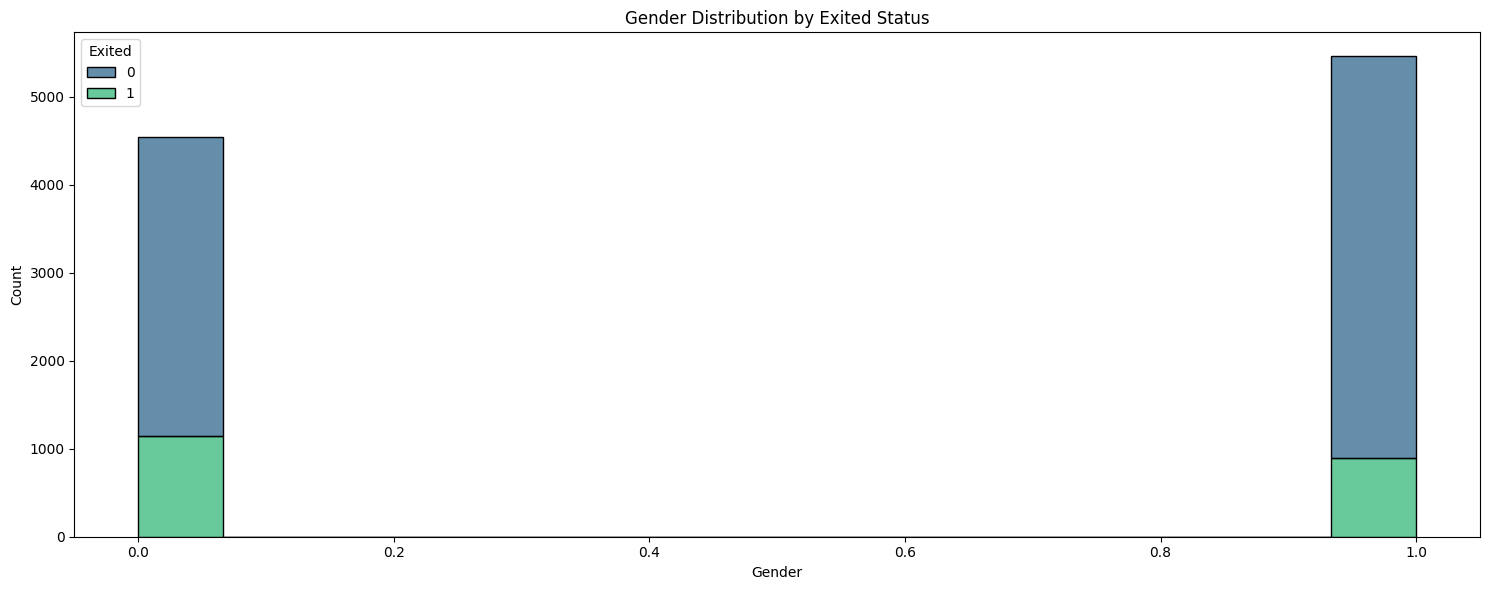

In [15]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df, x='Gender', hue='Exited',  multiple="stack", palette="viridis")
plt.title('Gender Distribution by Exited Status')

plt.tight_layout()
plt.show()

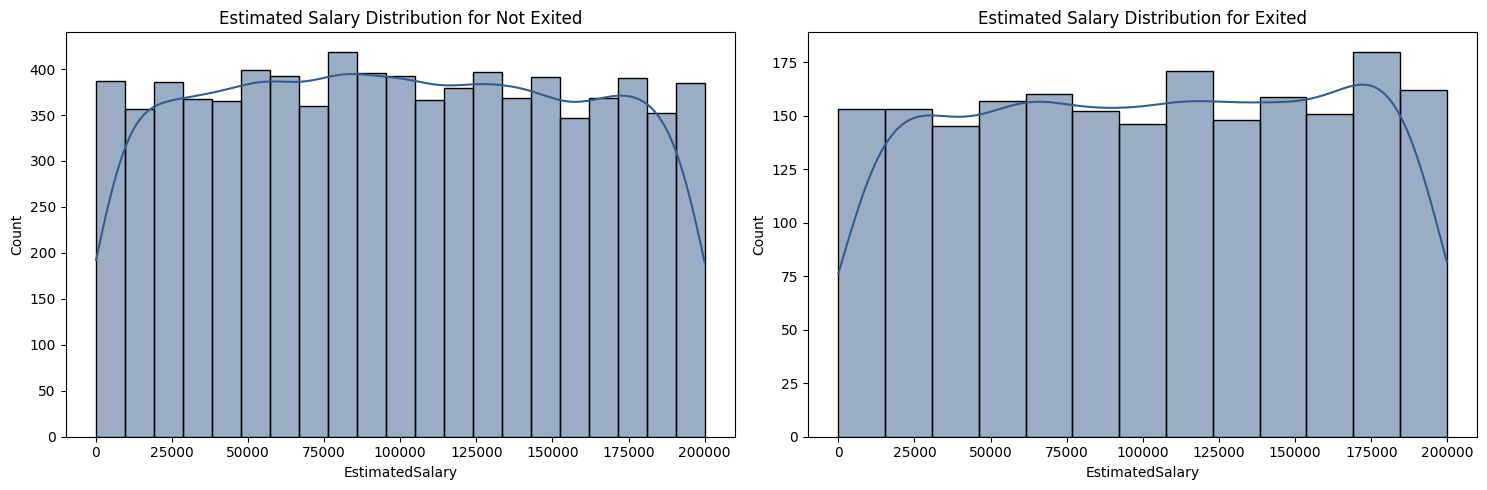

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.histplot(data=df.loc[df['Exited'] == 0], x="EstimatedSalary", kde=True, color=sns.color_palette("viridis")[1])
plt.title("Estimated Salary Distribution for Not Exited")

plt.subplot(1, 2, 2)
sns.histplot(data=df.loc[df['Exited'] == 1], x="EstimatedSalary", kde=True, color=sns.color_palette("viridis")[1])
plt.title("Estimated Salary Distribution for Exited")

plt.tight_layout()
plt.show()

In [17]:
mode = df['EstimatedSalary'][df['Exited'] == 0].mode()[0]
mean = df['EstimatedSalary'][df['Exited'] == 0].mean()
median = df['EstimatedSalary'][df['Exited'] == 0].median()
mode_exit = df['EstimatedSalary'][df['Exited'] == 1].mode()[0]
mean_exit= df['EstimatedSalary'][df['Exited'] == 1].mean()
median_exit = df['EstimatedSalary'][df['Exited'] == 1].median()

print("-----------------------------------------------------")
print("|    Statistics    |  Exited = 0 |  Exited= 1       |")
print("-----------------------------------------------------")
print(f"| Mode             |  {mode:<9}  |  {mode_exit:<14}  |")
print(f"| Median           |  {median:<9}  |  {median_exit:<14.2f}  |")
print(f"| Mean             |  {mean:<9.2f}  |  {mean_exit:<14.2f}  |")
print("-----------------------------------------------------")


-----------------------------------------------------
|    Statistics    |  Exited = 0 |  Exited= 1       |
-----------------------------------------------------
| Mode             |  24924.92   |  11.58           |
| Median           |  99645.04   |  102460.84       |
| Mean             |  99738.39   |  101465.68       |
-----------------------------------------------------


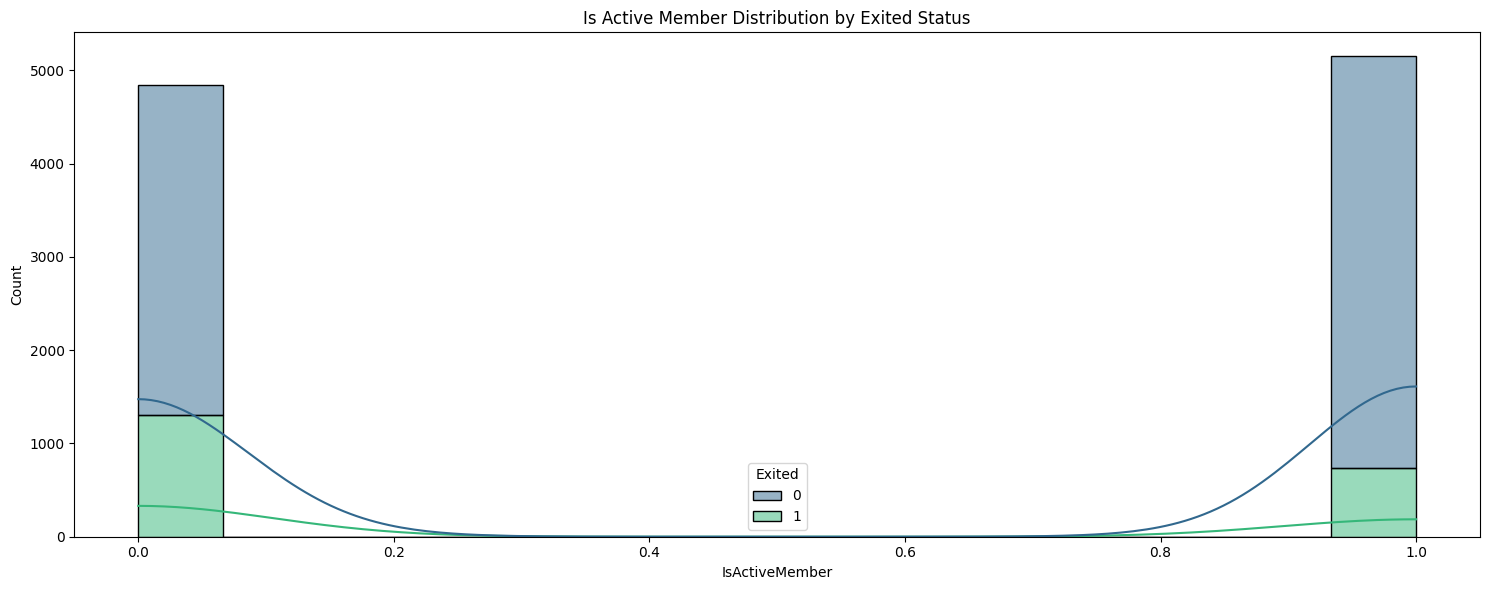

In [18]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df, x='IsActiveMember', hue='Exited',  multiple="stack",kde=True,  palette="viridis")
plt.title('Is Active Member Distribution by Exited Status')

plt.tight_layout()
plt.show()

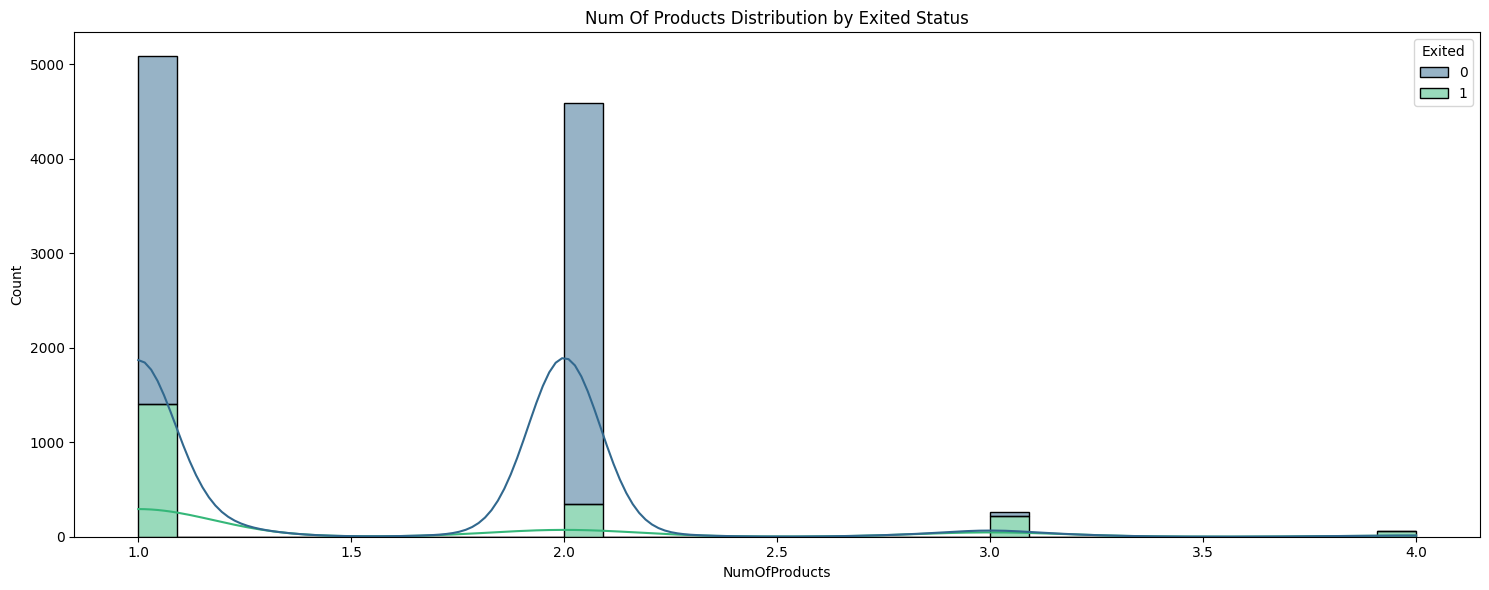

In [19]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df, x='NumOfProducts', hue='Exited',  multiple="stack",kde=True,  palette="viridis")
plt.title('Num Of Products Distribution by Exited Status')

plt.tight_layout()
plt.show()

In [20]:
churn_count = df[df['Exited'] == 1].groupby('Geography').size().reset_index(name='churn_count')

non_churn_count = df[df['Exited'] == 0].groupby('Geography').size().reset_index(name='non_churn_count')

combined_count = churn_count.merge(non_churn_count, on='Geography')

total_count = df['Geography'].value_counts().reset_index()
total_count.columns = ['Geography', 'total_count']
combined_count = combined_count.merge(total_count, on='Geography')
combined_count['churn_percentage'] = (combined_count['churn_count'] / combined_count['total_count']).round(4) * 100

combined_count


,Geography,churn_count,non_churn_count,total_count,churn_percentage
0,France,810,4204,5014,16.15
1,Germany,814,1695,2509,32.44
2,Spain,413,2064,2477,16.67


In [21]:
df['Geography'] = df['Geography'].map({'France': 1, 'Germany': 2, 'Spain': 3})

In [22]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)


In [23]:
df.head()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,1,0,42,2,0.00,1,1,1,101348.88,1
1,2,608,3,0,41,1,83807.86,1,0,1,112542.58,0
2,3,502,1,0,42,8,159660.80,3,1,0,113931.57,1
3,4,699,1,0,39,1,0.00,2,0,0,93826.63,0
4,5,850,3,0,43,2,125510.82,1,1,1,79084.10,0


In [24]:
X_train, X_test, y_train, y_test =train_test_split(df.drop('Exited',axis=1),df['Exited'],test_size=0.3)

#Naive Bayes


In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8303333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2417
           1       0.68      0.24      0.35       583

    accuracy                           0.83      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.81      0.83      0.80      3000



# Decision Tree

With max_depth = 5

In [28]:
from sklearn.tree import DecisionTreeClassifier

modelo_tree = DecisionTreeClassifier(max_depth=5)

modelo_tree.fit(X_train,y_train)

acc_tree = round(modelo_tree.score(X_train,y_train) * 100, 2)
predict_tree=modelo_tree.predict(X_test)
print("Accuracy of the Decision Tree Classifie model is: {}".format(acc_tree))

Accuracy of the Decision Tree Classifie model is: 85.64


With max_depth = 10

In [29]:
from sklearn.tree import DecisionTreeClassifier

modelo_tree = DecisionTreeClassifier(max_depth=10)

modelo_tree.fit(X_train,y_train)

acc_tree = round(modelo_tree.score(X_train,y_train) * 100, 2)
predict_tree=modelo_tree.predict(X_test)
print("Accuracy of the Decision Tree Classifie model is: {}".format(acc_tree))

Accuracy of the Decision Tree Classifie model is: 90.27


# Randon Forest

With max_depth = 5

In [30]:
from sklearn.ensemble import RandomForestClassifier
modelo_randon = RandomForestClassifier(n_estimators=5)
modelo_randon.fit(X_train,y_train)


acc_randon_tree = round(modelo_randon.score(X_train,y_train) * 100, 2)
print("Accuracy of the Random Forest  model is: {}".format(acc_randon_tree))
predicao_randon=modelo_randon.predict(X_test)

Accuracy of the Random Forest  model is: 97.7


With max_depth = 10

In [31]:
modelo_randon = RandomForestClassifier(n_estimators=10)
modelo_randon.fit(X_train,y_train)

acc_randon_tree = round(modelo_randon.score(X_train,y_train) * 100, 2)
print("Accuracy of the Random Forest  model is: {}".format(acc_randon_tree))
predicao_randon=modelo_randon.predict(X_test)

Accuracy of the Random Forest  model is: 98.24


# XGBoost

## Without Parameters

In [32]:
xgb = xGBRegressor()
xgb.fit(X_train,y_train)
xgbtd=xgb.predict(X_train)
xgbr2=r2_score(y_train,xgbtd)

In [33]:
xgbr2 = r2_score(y_train, xgbtd)

print('R-squared for the test set:', xgbr2*100)

R-squared for the test set: 82.8706908205276


## With Parameters

In [34]:
xgb = xGBRegressor(max_depth=10,eval_metric='rmse',colsample_bytree=0.6)
xgb.fit(X_train,y_train)
xgbtd=xgb.predict(X_train)
xgbr2=r2_score(y_train,xgbtd)

In [35]:
xgbr2 = r2_score(y_train, xgbtd)

print('R-squared for the test set:', xgbr2*100)

R-squared for the test set: 99.61619356957915
